<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup as BeSo

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [2]:
j_list = pd.read_csv("./data/job_listings.csv")
print(j_list.shape)
j_list.head()

(426, 3)


,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [3]:
import requests

description = []

for i in j_list["description"]:
    soup = BeSo(i, "html.parser")
    clean_soup = re.sub('["\"]', ' ', soup.get_text())
    clean_soup = clean_soup.replace("\\n", " ")
    description.append(clean_soup)
j_list["description"] = description
j_list.head()

,Unnamed: 0,description,title
0,0,b Job Requirements: Conceptual understanding i...,Data scientist
1,1,"b'Job Description As a Data Scientist 1, you ...",Data Scientist I
2,2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level
3,3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist
4,4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist


## 2) Use Spacy to tokenize the listings 

In [4]:
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)
j_list["description"] = j_list["description"].apply(lambda x: x.lower())
nlp.max_length = 2500000

text = str(j_list["description"])
doc = nlp(text)

STOP_WORDS = nlp.Defaults.stop_words
STOP_WORDS = nlp.Defaults.stop_words.union("     ", "b", "job", "requirement", "\n", "     ", "\n                  ",
                                          "                       \n", "'\n'", "'     '", "     ", "'     '")

print([token.lemma_ for token in doc if (token.is_stop != True) and (token.is_punct != True)])

['0', '     ', 'b', 'job', 'requirement', 'conceptual', 'understanding', '\n', '1', '     ', "b'job", 'description', ' ', 'data', 'scientist', '1', '\n', '2', '     ', "b'as", 'data', 'scientist', 'work', 'c', '\n', '3', '     ', "b'$4,969", '$', '6,756', 'monthcontractunder', 'gen', '\n', '4', '     ', "b'location", 'usa', '\\xe2\\x80\\x93', 'multiple', 'location', '\n                             ', '                       \n', '421', '   ', 'b', 'want', 'fantastic', '\n', '422', '   ', "b'internshipat", 'uber', 'ignite', 'opportunity', '\n', '423', '   ', "b'$200,000", '$', '350,000', 'yeara', 'million', 'people', '\n', '424', '   ', 'b', 'senior', 'datum', 'scientist', 'job', 'description', ' ', '\n', '425', '   ', "b'cerner", 'intelligence', 'new', 'innovative', 'org', '\n', 'description', 'length', '426', 'dtype', 'object']


In [5]:
STOP_WORDS = nlp.Defaults.stop_words
STOP_WORDS = nlp.Defaults.stop_words.union("     ", "b", "job", "requirement", "\n", "     ", "\n                  ",
                                          "                       \n", "'\n'", "'     '", "     ", "'     '", "000",
                                          "100", "100 000", "11", "12", "yes")

tokens = []

for doc in tokenizer.pipe(j_list["description"], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.text.lower() not in STOP_WORDS) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())
        
    tokens.append(doc_tokens)

j_list["tokens"] = tokens
print(j_list.shape)
j_list.head()

(426, 4)


,Unnamed: 0,description,title,tokens
0,0,b job requirements: conceptual understanding i...,Data scientist,"[job, requirements:, conceptual, understanding..."
1,1,"b'job description as a data scientist 1, you ...",Data Scientist I,"[b'job, description, data, scientist, 1,, help..."
2,2,b'as a data scientist you will be working on c...,Data Scientist - Entry Level,"[b'as, data, scientist, working, consulting, b..."
3,3,"b'$4,969 - $6,756 a monthcontractunder the gen...",Data Scientist,"[b'$4,969, $6,756, monthcontractunder, general..."
4,4,b'location: usa \xe2\x80\x93 multiple location...,Data Scientist,"[b'location:, usa, \xe2\x80\x93, multiple, loc..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [6]:
# CountVectorizer with hyperparameters
data = j_list["description"]
c_vect = CountVectorizer(lowercase=True,
                         stop_words="english",
                         min_df=4,
                         max_df=0.25,
                         ngram_range=(1,3),
                         max_features=5000)

# Fit CountVectorizer, get sparse data_matrix(dtm)

c_vect.fit(data)

dtm = c_vect.transform(data)

dtm = pd.DataFrame(dtm.todense(),columns=c_vect.get_feature_names())
print(dtm.shape)
dtm.head()

(426, 5000)


,000,000 employees,10,10 years,100,100 000,11,12,12 months,15,...,years relevant,years relevant work,years work,years work experience,years working,years xe2,years xe2 x80,yes,york,york city
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

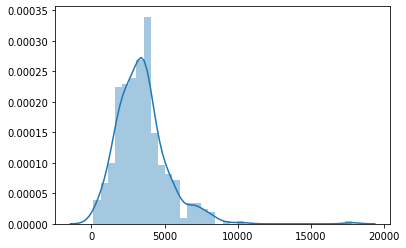

In [7]:
import seaborn as sns

doc_len = [len(doc) for doc in data]

sns.distplot(doc_len);

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [8]:
def tokenize(document):
    
    doc = nlp(document, disable=["parser", "ner"])
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [9]:
# Instantiation of TFIDFVectorizer

tfidf = TfidfVectorizer(stop_words="english",
                        min_df=0.18,
                        max_df=0.4,
                        ngram_range=(1,2),
                        tokenizer=tokenize)

# fit_transform dtm to instantiated tfidf
# Fit feature DataFrame

dtm = tfidf.fit_transform(data)
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# Print Feature Matrix and shape

print(dtm.shape)
dtm.head()

(426, 218)


,+,+ year,2,3,5,able,action,actionable,age,algorithm,...,value,variety,verbal,veteran,veteran status,vision,visualization,way,write,year experience
0,0.000000,0.000000,0.232374,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.188335,0.0
1,0.070828,0.077316,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.069744,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.159529,0.071271,0.0
2,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.255254,0.000000,0.185880,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
3,0.000000,0.000000,0.000000,0.0,0.139385,0.0,0.149732,0.000000,0.133248,0.000000,...,0.0,0.0,0.0,0.114968,0.130167,0.0,0.0,0.000000,0.000000,0.0
4,0.331410,0.361766,0.411460,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [10]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=7, algorithm="kd_tree")
knn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                 radius=1.0)

In [11]:
data[25][:100]

'b as a data scientist for ads measurement in the partners org you will work on projects to demonstra'

In [14]:
desired_ds_job = ["""
Data Scientist wanted for humanitarian corporation. Flexible hours, remote work, and paid vacations available.
"""]

In [15]:
new = tfidf.transform(desired_ds_job)

In [16]:
knn.kneighbors(new.todense())

(array([[1., 1., 1., 1., 1., 1., 1.]]),
 array([[199,  20, 350, 200,  99, 368, 329]]))

In [21]:
data[368]

"b job description global good is a collaborative effort between bill gates and intellectual ventures (iv) to tackle humanity's toughest problems through invention, focusing on developing countries. we work with governments, ngos, and commercial partners around the world to conceive, develop, and deploy inventions that save lives. you\\xe2\\x80\\x99ll be partnering with key personnel at global good and work closely with creative world-class business professionals, scientists and inventors at iv and the iv lab to bring our ideas through innovation and into reality. the renewable energy group seeks a data scientist to collaborate with a growing team of research scientists, software engineers, and data scientists who are building a simulation platform to study large-scale renewable energy integration on the electric grid. the simulation results will provide decision support for future electric grid design, operation, and policy making. responsibilities mine and analyze data from renewable

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 